In [40]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [41]:
# Define paths
input_dir = '/kaggle/input/updatingdataset/resized_images'  # Dataset path
base_split_path = '/kaggle/working/split_dataset'
train_dir = os.path.join(base_split_path, 'train')
val_dir = os.path.join(base_split_path, 'validation')
test_dir = os.path.join(base_split_path, 'test')

# Create split directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [42]:
# Split dataset into train, validation, and test sets
for class_folder in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_folder)
    if os.path.isdir(class_path):  # Ensure it's a directory
        # List all files in the class directory
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Split files into train (70%), validation (15%), and test (15%) sets
        train_files, temp_files = train_test_split(files, test_size=0.3, random_state=42, stratify=None)  # 70% train
        val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)  # 15% val, 15% test
        
        # Create class subdirectories
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)
        
        # Copy files to train directory
        for file in train_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(train_dir, class_folder, file))
        # Copy files to validation directory
        for file in val_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(val_dir, class_folder, file))
        # Copy files to test directory
        for file in test_files:
            shutil.copy(os.path.join(class_path, file), os.path.join(test_dir, class_folder, file))

print("Dataset successfully split into train, validation, and test sets.")

Dataset successfully split into train, validation, and test sets.


In [43]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2

# Load ResNet50 base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use as a feature extractor
resnet_base.trainable = False

# Build the model
model = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),  # Pool the feature maps
    layers.BatchNormalization(),
    
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dropout(0.5),
    
    layers.Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,154,118 (92.14 MB)

 Trainable params: 562,310 (2.15 MB)

 Non-trainable params: 23,591,808 (90.00 MB)

In [44]:
# Unfreeze the last few layers of the ResNet base
resnet_base.trainable = True

# Freeze all layers except the last few
for layer in resnet_base.layers[:-10]:  # Fine-tune only the last 10 layers
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,154,118 (92.14 MB)

 Trainable params: 5,027,974 (19.18 MB)

 Non-trainable params: 19,126,144 (72.96 MB)

In [45]:
# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights_dict  # Include class weights if the dataset is imbalanced
)

Epoch 1/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 148s 448ms/step - accuracy: 0.4018 - loss: 8.5400 - val_accuracy: 0.6375 - val_loss: 7.2159
Epoch 2/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 115s 394ms/step - accuracy: 0.5662 - loss: 7.3398 - val_accuracy: 0.7146 - val_loss: 6.3326
Epoch 3/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 396ms/step - accuracy: 0.5888 - loss: 6.8902 - val_accuracy: 0.5033 - val_loss: 7.5905
Epoch 4/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 396ms/step - accuracy: 0.6352 - loss: 6.3516 - val_accuracy: 0.7484 - val_loss: 5.4694
Epoch 5/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 397ms/step - accuracy: 0.6379 - loss: 5.9218 - val_accuracy: 0.7867 - val_loss: 4.9599
Epoch 6/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 395ms/step - accuracy: 0.6690 - loss: 5.3745 - val_accuracy: 0.6578 - val_loss: 4.8397
Epoch 7/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 397ms/step - accuracy: 0.6877 - loss: 5.0247 - val_accuracy: 0.5325 - val_loss: 4.8190
Epoch 8/30
286/286 ━━━━━━━━━━━━━━━━━━━━ 116s 396ms/step - accuracy: 0.6832 -

In [46]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.6162 - loss: 1.7732
Test Loss: 2.3895442485809326
Test Accuracy: 0.4287118911743164


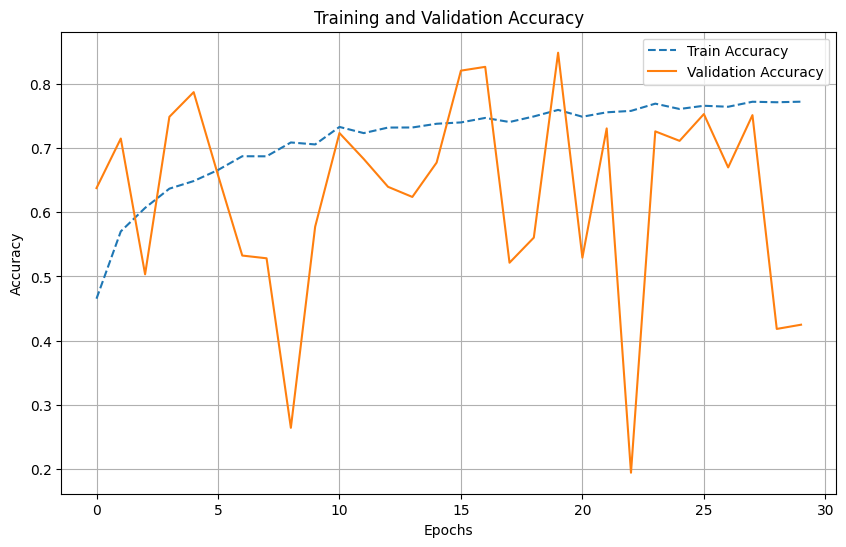

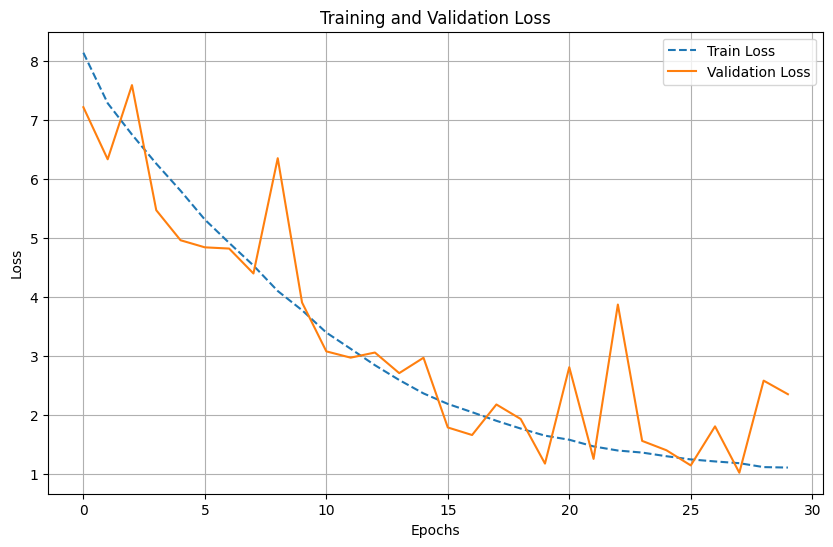

In [47]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

In [49]:
# Verify the classes in the test set
print("Test generator class indices:", test_generator.class_indices)
print("Classes in the test set:", len(test_generator.class_indices))

Test generator class indices: {'compound': 0, 'double_implants': 1, 'others': 2, 'resized_images': 3, 'single_implants': 4, 'steel_ball': 5}
Classes in the test set: 6


In [50]:
# Get class labels directly from the generator
class_labels = list(test_generator.class_indices.keys())
print("Class labels:", class_labels)

Class labels: ['compound', 'double_implants', 'others', 'resized_images', 'single_implants', 'steel_ball']


In [51]:
import os

# Check the contents of resized_images
print("Contents of resized_images directory:", os.listdir('/kaggle/input/updatingdataset/resized_images'))


Contents of resized_images directory: ['single_implants', 'double_implants', 'steel_ball', 'compound', 'others']


In [52]:
# Remove 'resized_images' from class labels
class_labels = [label for label in test_generator.class_indices.keys() if label != 'resized_images']
print("Filtered class labels:", class_labels)


Filtered class labels: ['compound', 'double_implants', 'others', 'single_implants', 'steel_ball']


In [53]:
# Get valid class indices
valid_indices = [index for label, index in test_generator.class_indices.items() if label != 'resized_images']

# Filter out invalid entries from y_true and y_pred_classes
y_true = [y for y in y_true if y in valid_indices]
y_pred_classes = [y for y in y_pred_classes if y in valid_indices]


In [54]:
from sklearn.metrics import classification_report

# Generate classification report with valid classes
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


                 precision    recall  f1-score   support

       compound       0.57      0.60      0.58        65
double_implants       1.00      0.06      0.12       127
         others       0.37      1.00      0.54      1006
single_implants       1.00      0.11      0.20      1324
     steel_ball       0.97      0.21      0.34       529

       accuracy                           0.43      3051
      macro avg       0.78      0.40      0.36      3051
   weighted avg       0.78      0.43      0.34      3051



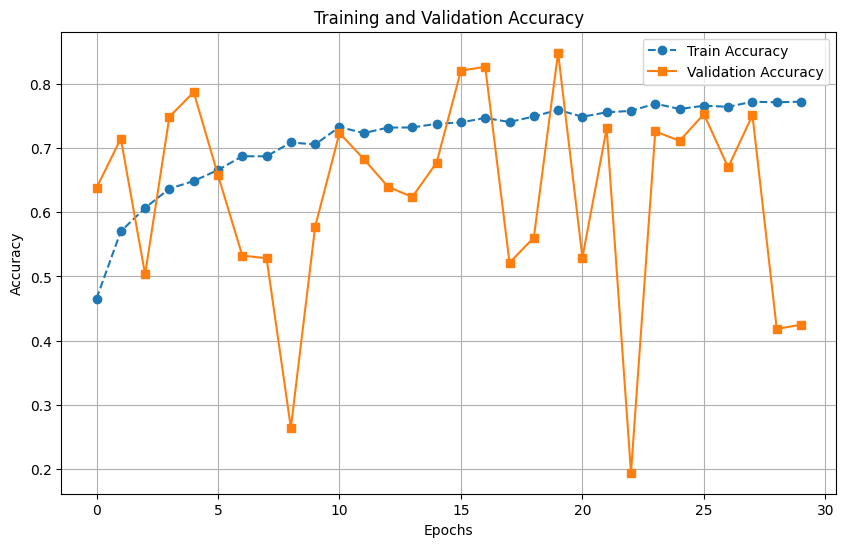

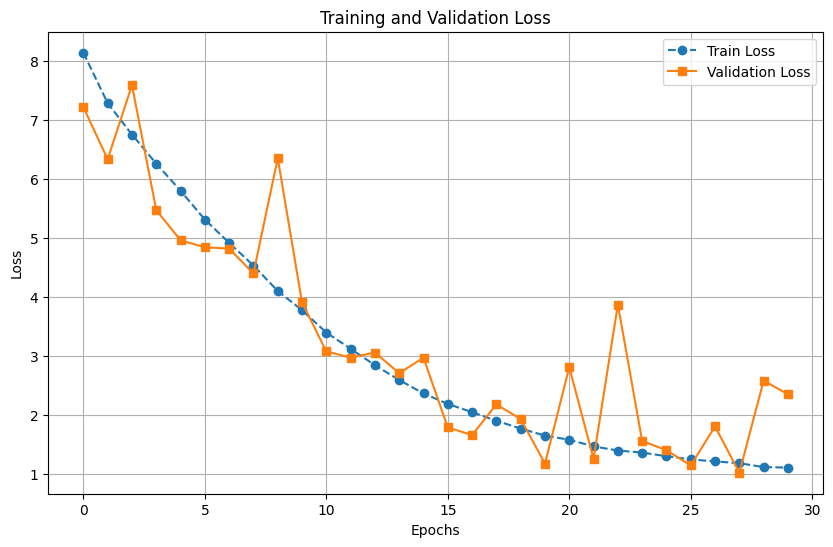

In [55]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='-', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step


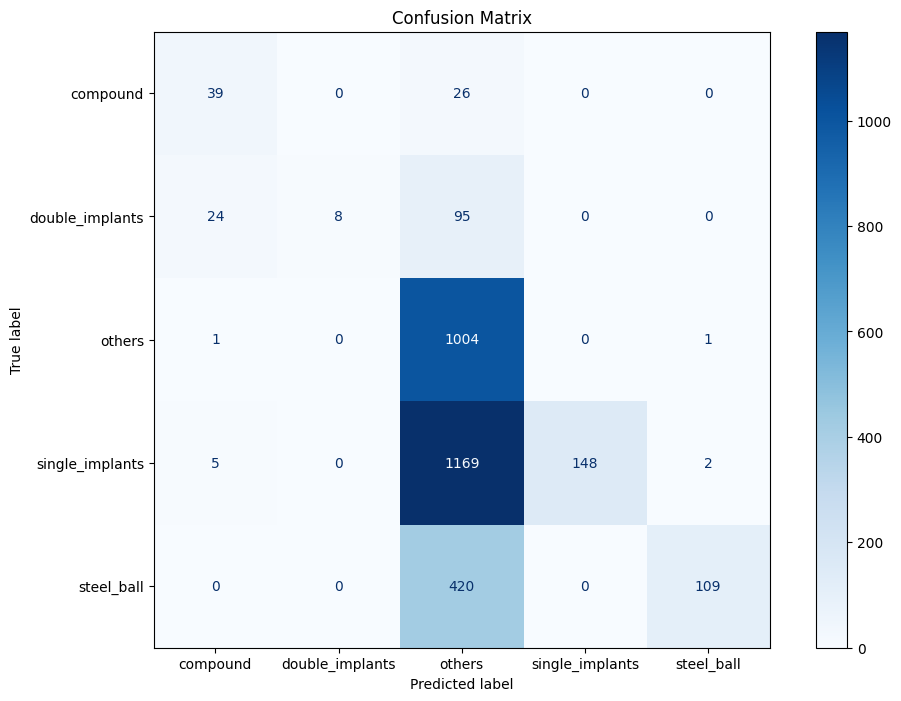

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions and ground truth
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 8))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

In [57]:
import pandas as pd

# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('/kaggle/working/training_history.csv', index=False)
print("Training history saved successfully.")

# Save the trained model
model.save('/kaggle/working/final_resnet_model.h5')
print("Trained model saved successfully.")

Training history saved successfully.
Trained model saved successfully.
